#  Análisis de Sentimientos sobre Opiniones de Machu Picchu  
### Proyecto de Minería de Datos — Universidad Peruana Unión (UPeU)

**Autor:** Deyvis Quispe Mamani  
**Curso:** Minería de Datos  
**Docente:** Abel Angel Sullon Macalupu  
**Periodo Académico:** 2025-II  
**Fecha:** Octubre 2025  

---

##  Descripción General

El presente proyecto aplica técnicas de **Procesamiento de Lenguaje Natural (NLP)** para analizar opiniones reales y simuladas de visitantes sobre el sitio turístico **Machu Picchu**.  
El objetivo principal es **clasificar automáticamente el sentimiento** (positivo, negativo o neutral) de cada opinión, permitiendo obtener una visión general del grado de satisfacción de los turistas.

El trabajo incluye:

-  **Limpieza y preprocesamiento** de texto en español (eliminación de stopwords, tildes y caracteres no alfabéticos).  
-  **Análisis exploratorio** con nubes de palabras por categoría de sentimiento.  
-  **Entrenamiento de un modelo supervisado** (TF-IDF + Regresión Logística).  
-  **Evaluación de desempeño** mediante métricas de precisión, recall, F1-score y matriz de confusión.  
-  **Función de predicción** que permite inferir el sentimiento de nuevas opiniones escritas en español.

---

##  Objetivos del Proyecto

1. Aplicar técnicas de minería de texto y análisis de sentimientos en idioma español.  
2. Comprender la relación entre lenguaje y percepción turística.  
3. Desarrollar un modelo funcional que clasifique automáticamente el sentimiento de opiniones textuales.  
4. Presentar resultados visuales y métricas interpretables.

---

##  Tecnologías Utilizadas

- **Python 3.10+**  
- **Bibliotecas:**  
  - `pandas`, `numpy`, `matplotlib`, `wordcloud`  
  - `scikit-learn` (TF-IDF, LogisticRegression)  
  - `nltk` (stopwords en español)  
  - `unidecode` (normalización de texto)  
- **Entorno de ejecución:** Google Colab  
- **Formato de entrega:** ` link github` ,`.ipynb` y `.csv`  

---


In [12]:
# Instalamos las dependencias necesarias
!pip -q install unidecode wordcloud scikit-learn nltk

In [13]:
import pandas as pd, re, unicodedata, numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

CSV_PATH = "/content/machupicchu_opiniones.csv"
df = pd.read_csv(CSV_PATH)
df.head()

,id,fecha,fuente,lugar,subzona,opinion,puntaje,sentimiento
0,1,2023-09-08,Google Maps,Machu Picchu,Ciudadela,El precio es elevado para lo que ofrecen.,2,negativo
1,2,2024-08-27,Instagram,Machu Picchu,Machu Picchu,El precio es elevado para lo que ofrecen.,1,negativo
2,3,2024-06-01,Blog,Machu Picchu,Machu Picchu,La organización del ingreso fue ágil y el pers...,4,positivo
3,4,2023-08-14,Instagram,Machu Picchu,Aguas Calientes,El guía se apuró mucho y no respondió preguntas.,2,negativo
4,5,2023-12-15,Twitter,Machu Picchu,Ciudadela,"El lugar es interesante, aunque similar a lo q...",3,neutral


Tamaño del dataset: (60, 8)

Columnas: ['id', 'fecha', 'fuente', 'lugar', 'subzona', 'opinion', 'puntaje', 'sentimiento']

Muestra aleatoria:


,id,fecha,fuente,lugar,subzona,opinion,puntaje,sentimiento
0,1,2023-09-08,Google Maps,Machu Picchu,Ciudadela,El precio es elevado para lo que ofrecen.,2,negativo
5,6,2024-01-25,TripAdvisor,Machu Picchu,Huayna Picchu,"A pesar de la altura, el recorrido es llevader...",4,positivo
36,37,2023-03-04,Instagram,Machu Picchu,Montaña Machu Picchu,"El lugar es interesante, aunque similar a lo q...",3,neutral
45,46,2024-11-22,Google Maps,Machu Picchu,Puerta del Sol,La organización del ingreso fue ágil y el pers...,4,positivo
13,14,2025-05-13,TripAdvisor,Machu Picchu,Ciudadela,El guía se apuró mucho y no respondió preguntas.,2,negativo



Distribución de sentimiento:
sentimiento
negativo    21
neutral     19
positivo    20
Name: count, dtype: int64


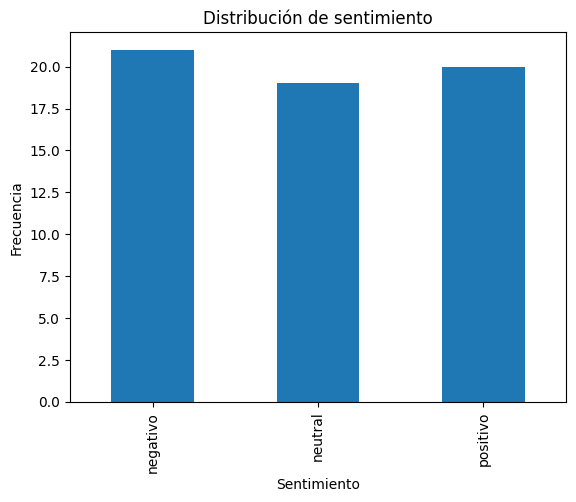

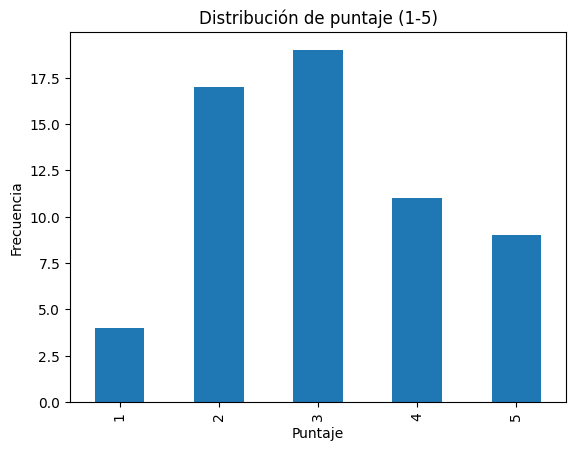

In [14]:
print("Tamaño del dataset:", df.shape)
print("\nColumnas:", list(df.columns))
print("\nMuestra aleatoria:")
display(df.sample(5, random_state=42))

# Distribución de etiquetas
label_counts = df['sentimiento'].value_counts().sort_index()
print("\nDistribución de sentimiento:")
print(label_counts)

plt.figure()
label_counts.plot(kind='bar')
plt.title("Distribución de sentimiento")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de puntajes
plt.figure()
df['puntaje'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de puntaje (1-5)")
plt.xlabel("Puntaje")
plt.ylabel("Frecuencia")
plt.show()

In [15]:
spanish_stop = set(stopwords.words('spanish'))
# Agregamos los stopwords de dominio
domain_stop = {"machu", "picchu", "ciudadela", "huayna", "puerta", "sol", "montana", "aguas", "calientes"}
spanish_stop |= domain_stop

def clean_text(s):
    if pd.isna(s):
        return ""
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)      # URLs
    s = re.sub(r"@[\w_]+", " ", s)              # menciones
    s = re.sub(r"#\w+", " ", s)                 # hashtags
    s = re.sub(r"[^a-záéíóúñü\s]", " ", s)      # para quitar números y símbolos
    s = unidecode(s)                             # para quitar acentos
    tokens = [t for t in s.split() if t not in spanish_stop and len(t) > 2]
    return " ".join(tokens)

df['opinion_clean'] = df['opinion'].apply(clean_text)
df[['opinion', 'opinion_clean']].head()

,opinion,opinion_clean
0,El precio es elevado para lo que ofrecen.,precio elevado ofrecen
1,El precio es elevado para lo que ofrecen.,precio elevado ofrecen
2,La organización del ingreso fue ágil y el pers...,organizacion ingreso agil personal amable
3,El guía se apuró mucho y no respondió preguntas.,guia apuro respondio preguntas
4,"El lugar es interesante, aunque similar a lo q...",lugar interesante aunque similar esperaba fotos


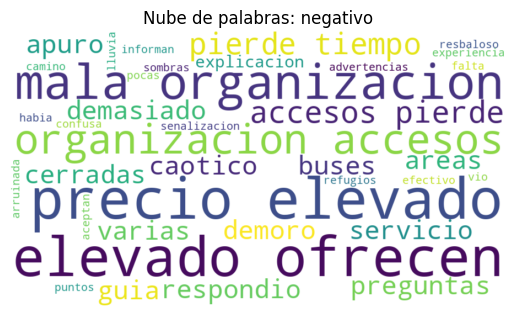

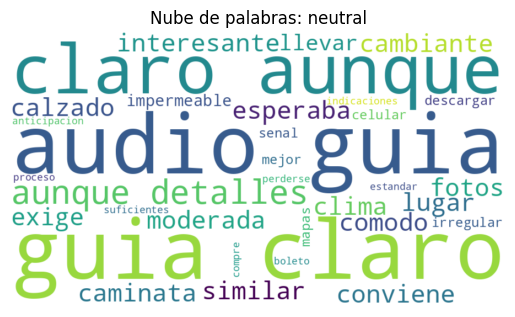

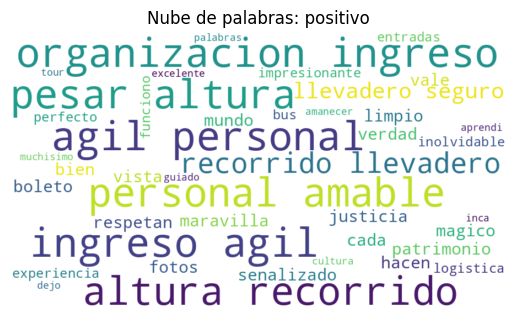

In [16]:
def plot_wordcloud(texts, title):
    text = " ".join(texts)
    wc = WordCloud(width=900, height=500, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for label in sorted(df['sentimiento'].unique()):
    plot_wordcloud(df.loc[df['sentimiento']==label, 'opinion_clean'], f"Nube de palabras: {label}")

In [17]:
X = df['opinion_clean'].fillna("")
y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Mezcla de n-gramas palabra y caracter
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
Xtr = vectorizer.fit_transform(X_train)
Xte = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000, n_jobs=None, multi_class='auto')
clf.fit(Xtr, y_train)

pred = clf.predict(Xte)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negativo       1.00      0.40      0.57         5
     neutral       1.00      0.80      0.89         5
    positivo       0.56      1.00      0.71         5

    accuracy                           0.73        15
   macro avg       0.85      0.73      0.72        15
weighted avg       0.85      0.73      0.72        15



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


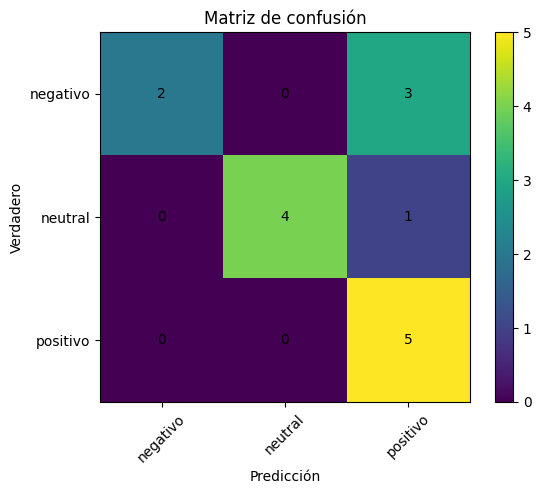

In [18]:
labels = sorted(y.unique())
cm = confusion_matrix(y_test, pred, labels=labels)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión")
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.colorbar()
plt.show()

In [19]:
def predecir_sentimiento(texto: str):
    limpio = clean_text(texto)
    vec = vectorizer.transform([limpio])
    return clf.predict(vec)[0]

ejemplos = [
    "El amanecer fue espectacular, una de las mejores vistas de mi vida",
    "La experiencia estuvo bien, aunque algo de lluvia complicó el recorrido",
    "Muy caro y demasiadas colas, no volvería"
]
for e in ejemplos:
    print(e, "->", predecir_sentimiento(e))

El amanecer fue espectacular, una de las mejores vistas de mi vida -> positivo
La experiencia estuvo bien, aunque algo de lluvia complicó el recorrido -> positivo
Muy caro y demasiadas colas, no volvería -> positivo


In [20]:
# Guardamos el vectorizador y el modelo para reutilizar
import pickle
with open("vectorizer_es.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("modelo_sentimiento.pkl", "wb") as f:
    pickle.dump(clf, f)
print("Guardados: vectorizer_es.pkl, modelo_sentimiento.pkl")

Guardados: vectorizer_es.pkl, modelo_sentimiento.pkl
